In [1]:
import numpy as np
import numpy
import pandas
import scanpy
import scanpy as sc
import anndata
import seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import math
import random

from collections import OrderedDict

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.17.0 scipy==1.2.1 pandas==0.25.0 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Simulating a single cell experiment

1. `cell_no` – number of rows/cells.
2. `gene_no` – number of columns/genes.
3. We simulate count matrix by assuming it follows a hierarchical process: `poisson(lognormal(0, 0.1))`. This can be argued to make sense: poisson simulates the bead and lognormal simulates the true expression of a gene. Better models are possible (e.g. assuming different genes have different expression rates, etc.).
4. We simulate velocity to follow a normal distribution with mu=0 and sigma=1.

In [2]:
def create_cell(gene_no, function, constants):
    result = []
    for i in range(gene_no):
        result.append(function(*constants))
    return numpy.array(result).reshape(1, -1)

In [3]:
def create_experiment(cell_no, gene_no, function, constants):
    experiment = numpy.zeros(shape=(cell_no, gene_no))
    for i in range(cell_no):
        experiment[i, :] = create_cell(gene_no, function, constants)
    return experiment

In [4]:
spliced = create_experiment(10, 5, lambda mu, sigma: numpy.random.poisson(numpy.random.lognormal(mu, sigma)), [0, 0.1])

In [5]:
spliced

array([[0., 0., 0., 0., 0.],
       [2., 0., 1., 0., 1.],
       [0., 0., 1., 0., 3.],
       [1., 2., 1., 0., 0.],
       [0., 1., 1., 2., 2.],
       [1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 2., 1.],
       [0., 0., 1., 0., 1.],
       [0., 3., 2., 0., 1.]])

In [6]:
velocity = create_experiment(10, 5, numpy.random.normal, [0, 1])

In [7]:
velocity

array([[-1.16542546e+00, -4.02332190e-02,  6.31166137e-01,
        -1.83824073e+00,  3.00463168e-01],
       [ 9.98267630e-01,  1.59567569e+00, -1.81121042e+00,
        -4.00122170e-01, -1.10271521e+00],
       [-9.64812241e-01,  7.85299124e-01,  1.12758384e-01,
         6.58918889e-01, -1.54344788e+00],
       [-2.85281157e+00,  5.85471064e-01,  2.03441106e-01,
         8.94617498e-01,  4.79796881e-01],
       [ 2.55622684e-01, -4.05531665e-01,  8.34243438e-01,
        -5.67391720e-01,  8.92327718e-01],
       [-6.89862869e-02, -2.95609340e-02, -4.86617273e-01,
        -9.42017164e-01, -8.30836305e-01],
       [ 1.06050472e+00,  8.63010323e-01, -7.83538350e-01,
         1.29240221e-01,  5.31003680e-02],
       [-7.81590764e-01,  1.58510528e+00, -8.76965525e-01,
         1.53223125e+00, -3.22432057e-01],
       [-2.72985406e+00,  3.49759892e-01, -1.53156407e+00,
         2.98077682e-04,  8.32048336e-01],
       [ 5.98791919e-01, -3.29555454e-01, -4.55968693e-01,
         5.14061058e-01

In [8]:
velocity.shape

(10, 5)

In [9]:
assert velocity.shape == spliced.shape

That's how we can choose an example cell's velocity

In [10]:
example_velocity = velocity[-3, :]
example_velocity

array([-0.78159076,  1.58510528, -0.87696553,  1.53223125, -0.32243206])

And an example cell

In [11]:
example_cell = spliced[-3, :]
example_cell

array([1., 0., 0., 2., 1.])

# The next bit is some rather easy linear algebra

We're just going to take a projection of velocity onto the position vector, and measure that. This will allow us to define and measure differentiation rate.

![velocity projection](https://trello-attachments.s3.amazonaws.com/5a982c9ba3afcf0a82b5b26c/5c84e116d5a3ed167f8ac28a/b4e329c442b2e809f7270ebf8ad8e07f/IMG_20190310_100347422.jpg)

# The cell above has made all the right life choices! See, her career narrative is showing a "clear, fairly linear development" along her chosen path. Before long, she'll be in a position of leadership and influence, recognised among many cells! We should all aspire to be like this cell!

In [12]:
def project(velocity, position):
    projection = numpy.dot(velocity, position)/numpy.linalg.norm(position)
    projection_vector = position/numpy.linalg.norm(position)*projection
    return projection, projection_vector

Exercise. Plot the following vectors and their respective projections on a sheet of paper

In [13]:
project([0, 1], [1, 0])

(0.0, array([0., 0.]))

In [14]:
project([0.1, 1], [1, 0])

(0.1, array([0.1, 0. ]))

In [15]:
project([0, 1], [1, 0.1])

(0.09950371902099893, array([0.0990099 , 0.00990099]))

In [16]:
project([1, 1], [2, 2])

(1.414213562373095, array([1., 1.]))

In [17]:
project([-1, -1], [2, 2])

(-1.414213562373095, array([-1., -1.]))

And that's how we can compute the projection for a single cell

In [18]:
project(velocity[-3, :], spliced[-3, :])

(0.8003461469825783,
 array([0.32673995, 0.        , 0.        , 0.65347989, 0.32673995]))

We can now compute the ratio of average neutral velocity to average differentiation velocity. Let's call that "differentiation factor"

In [19]:
def compute_differentiation(spliced, velocity):
    differentiation_speed = []
    neutral_speed = []
    for cell_no in range(velocity.shape[0]):
        p = spliced[cell_no, :]
        v = velocity[cell_no, :]
        speed_away, velocity_away = project(v, p)
        neutral = numpy.linalg.norm(v - velocity_away)
        if not math.isnan(speed_away) and not math.isnan(neutral):
            differentiation_speed.append(speed_away)
            neutral_speed.append(neutral)
    differentiation_factor = sum(differentiation_speed)/sum(neutral_speed)
    return differentiation_factor, neutral_speed, differentiation_speed

In [20]:
compute_differentiation(spliced, velocity)

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.15944069933102753,
 [2.8388401506346703,
  1.5283388472350536,
  3.0313284666690556,
  1.3883835303281202,
  0.8302550219206409,
  1.5653023320794865,
  2.388232083547167,
  3.2199017205213334,
  1.2518578610689859],
 [-0.37452304896012334,
  -1.4285858894126255,
  -0.6035658394012432,
  0.3410781364038925,
  -1.0633866785983304,
  0.22965347988235424,
  0.8003461469825783,
  -0.4946323222819827,
  -0.2830832380855136])

# Centralising the experiment and computing the differentiation factor

Before we can use this method we have to determine the correct origin. I suggest just using the most average cell as the origin. This can be achieved by recentrilising the entire experiment to put the hypothetical "average cell" in the middle. We don't have to touch the velocity vectors, because the transformation doesn't affect them.

In [21]:
def centralise_experiment(spliced):
    average_cell = spliced.sum(0)/spliced.shape[0]
    for i in range(spliced.shape[0]):
        spliced[i, :] -= average_cell 

In [22]:
spliced

array([[0., 0., 0., 0., 0.],
       [2., 0., 1., 0., 1.],
       [0., 0., 1., 0., 3.],
       [1., 2., 1., 0., 0.],
       [0., 1., 1., 2., 2.],
       [1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 2., 1.],
       [0., 0., 1., 0., 1.],
       [0., 3., 2., 0., 1.]])

In [23]:
centralise_experiment(spliced)

In [24]:
spliced

array([[-0.6, -0.6, -0.8, -0.6, -1.1],
       [ 1.4, -0.6,  0.2, -0.6, -0.1],
       [-0.6, -0.6,  0.2, -0.6,  1.9],
       [ 0.4,  1.4,  0.2, -0.6, -1.1],
       [-0.6,  0.4,  0.2,  1.4,  0.9],
       [ 0.4, -0.6, -0.8,  0.4, -0.1],
       [ 0.4, -0.6,  0.2,  0.4, -0.1],
       [ 0.4, -0.6, -0.8,  1.4, -0.1],
       [-0.6, -0.6,  0.2, -0.6, -0.1],
       [-0.6,  2.4,  1.2, -0.6, -0.1]])

# Now we can compute the differentiation factor

In [25]:
differentiation_factor, neutral_velocity, differentiation_velocity = compute_differentiation(spliced, velocity)

In [26]:
differentiation_velocity

[0.5788883544697109,
 0.2592020110487651,
 -1.4702777033934142,
 -0.6965823543431329,
 -0.07671462247850609,
 0.07432227544954736,
 -0.23867724099552717,
 0.9129875711677707,
 0.9768069277150104,
 -0.7421621653256812]

In [27]:
differentiation_factor

-0.02069217651462528

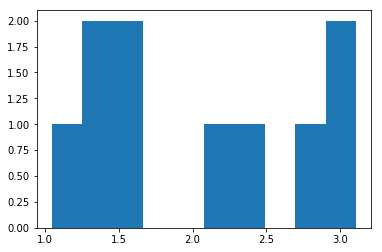

In [28]:
_ = plt.hist(neutral_velocity)

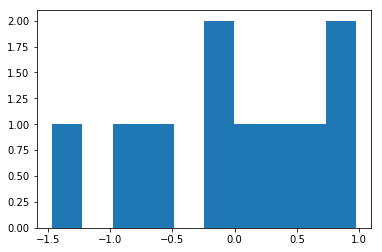

In [29]:
_ = plt.hist(differentiation_velocity)

# Load real data

In [30]:
import os

BATCH_LABELS = ("control", "treated")
batches = {}

for batch in BATCH_LABELS:
    filename = "tgfb1-5-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    batches[batch] = anndata.read(filename)

batches

{'control': AnnData object with n_obs × n_vars = 5347 × 4542 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'ALK5 signature', 'ALK1 signature', 'cVSMC signature', 'fibroblast signature'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
     uns: 'genes_before_highly_variable', 'genes_original', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'velocity_graph', 'velocity_graph_neg'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     varm: 'PCs'
     layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity',
 'treated': AnnData object with n_obs × n_vars = 7441 × 4542 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'ALK5 signature', 'ALK1 signature', 'cVSMC signature', 'fibroblast signature'
     var: 'gene_names', 'highly_variabl

## Look at the count matrix and the velocity layer

In [31]:
for batch, matrix in batches.items():
    print("Velocity layer for", batch)
    print(matrix.layers["velocity"])
    print("")
    
    print("Count matrix for", batch)
    print(matrix.X)
    print("")
    print("")

Velocity layer for control
[[-0.09120359  0.01786815  0.         ...  0.4137421   0.0247296
   1.3643273 ]
 [-0.08840107  0.03827929  0.01888847 ...  0.07878451  0.02602046
   0.31314468]
 [ 0.03272413  0.03529425  0.07284618 ...  0.11625859  0.17252812
   1.0580621 ]
 ...
 [-0.06659812  0.02048492  0.02560857 ...  0.06656477  0.10541851
   0.40407407]
 [ 0.00182727  0.03325369  0.05995736 ...  0.06975351  0.10583428
   0.4994623 ]
 [-0.08412629 -0.0133601   0.01913265 ...  0.14514339  0.10459487
   0.9343806 ]]

Count matrix for control
[[-0.90788656 -0.2491753  -0.15025607 ...  4.2555594  -0.28366247
   2.612499  ]
 [-0.86015934 -0.30013722 -0.17421411 ... -0.5452943  -0.28205174
  -1.2637209 ]
 [-0.7717205  -0.37379727 -0.13651977 ... -0.4965364  -0.26608557
   1.8831521 ]
 ...
 [-0.3423811  -0.48725897 -0.13000806 ...  0.12117454 -0.20493934
   0.5736941 ]
 [ 0.23939854 -0.49276173 -0.14041846 ...  0.1013722  -0.2036884
  -0.82635844]
 [ 0.2575336  -0.52828556 -0.15944576 ...  0.90

## Compute differentiation per batch

In [32]:
gdf = {"df": OrderedDict(), "neutral_velo": OrderedDict(), "df_velo": OrderedDict()}

for batch, matrix in batches.items():
    print("Computing differentiation for batch", batch)
    
    df, neutral_velo, df_velo = compute_differentiation(matrix.X, matrix.layers["velocity"])
    
    gdf["df"][batch] = df
    gdf["neutral_velo"][batch] = neutral_velo
    gdf["df_velo"][batch] = df_velo
        

Computing differentiation for batch control
Computing differentiation for batch treated


Title: Plot of neutral velocity

That's just for Ange: Neutral velocity is an RNA velocity component, obtained through decomposition of RNA velocity into a differentiation non-contributing vector, i.e. undirected movement as opposed to differentiation movement away from the origin of the HSVSMC cluster.

X axis title: histogram of neutral velocity

Y axis title: relative magnitude of neutral velocity

now printing df
control : 0.0365051422036496
treated : 0.0332401113132073
now printing neutral_velo
now printing df_velo


<Figure size 3600x2400 with 0 Axes>

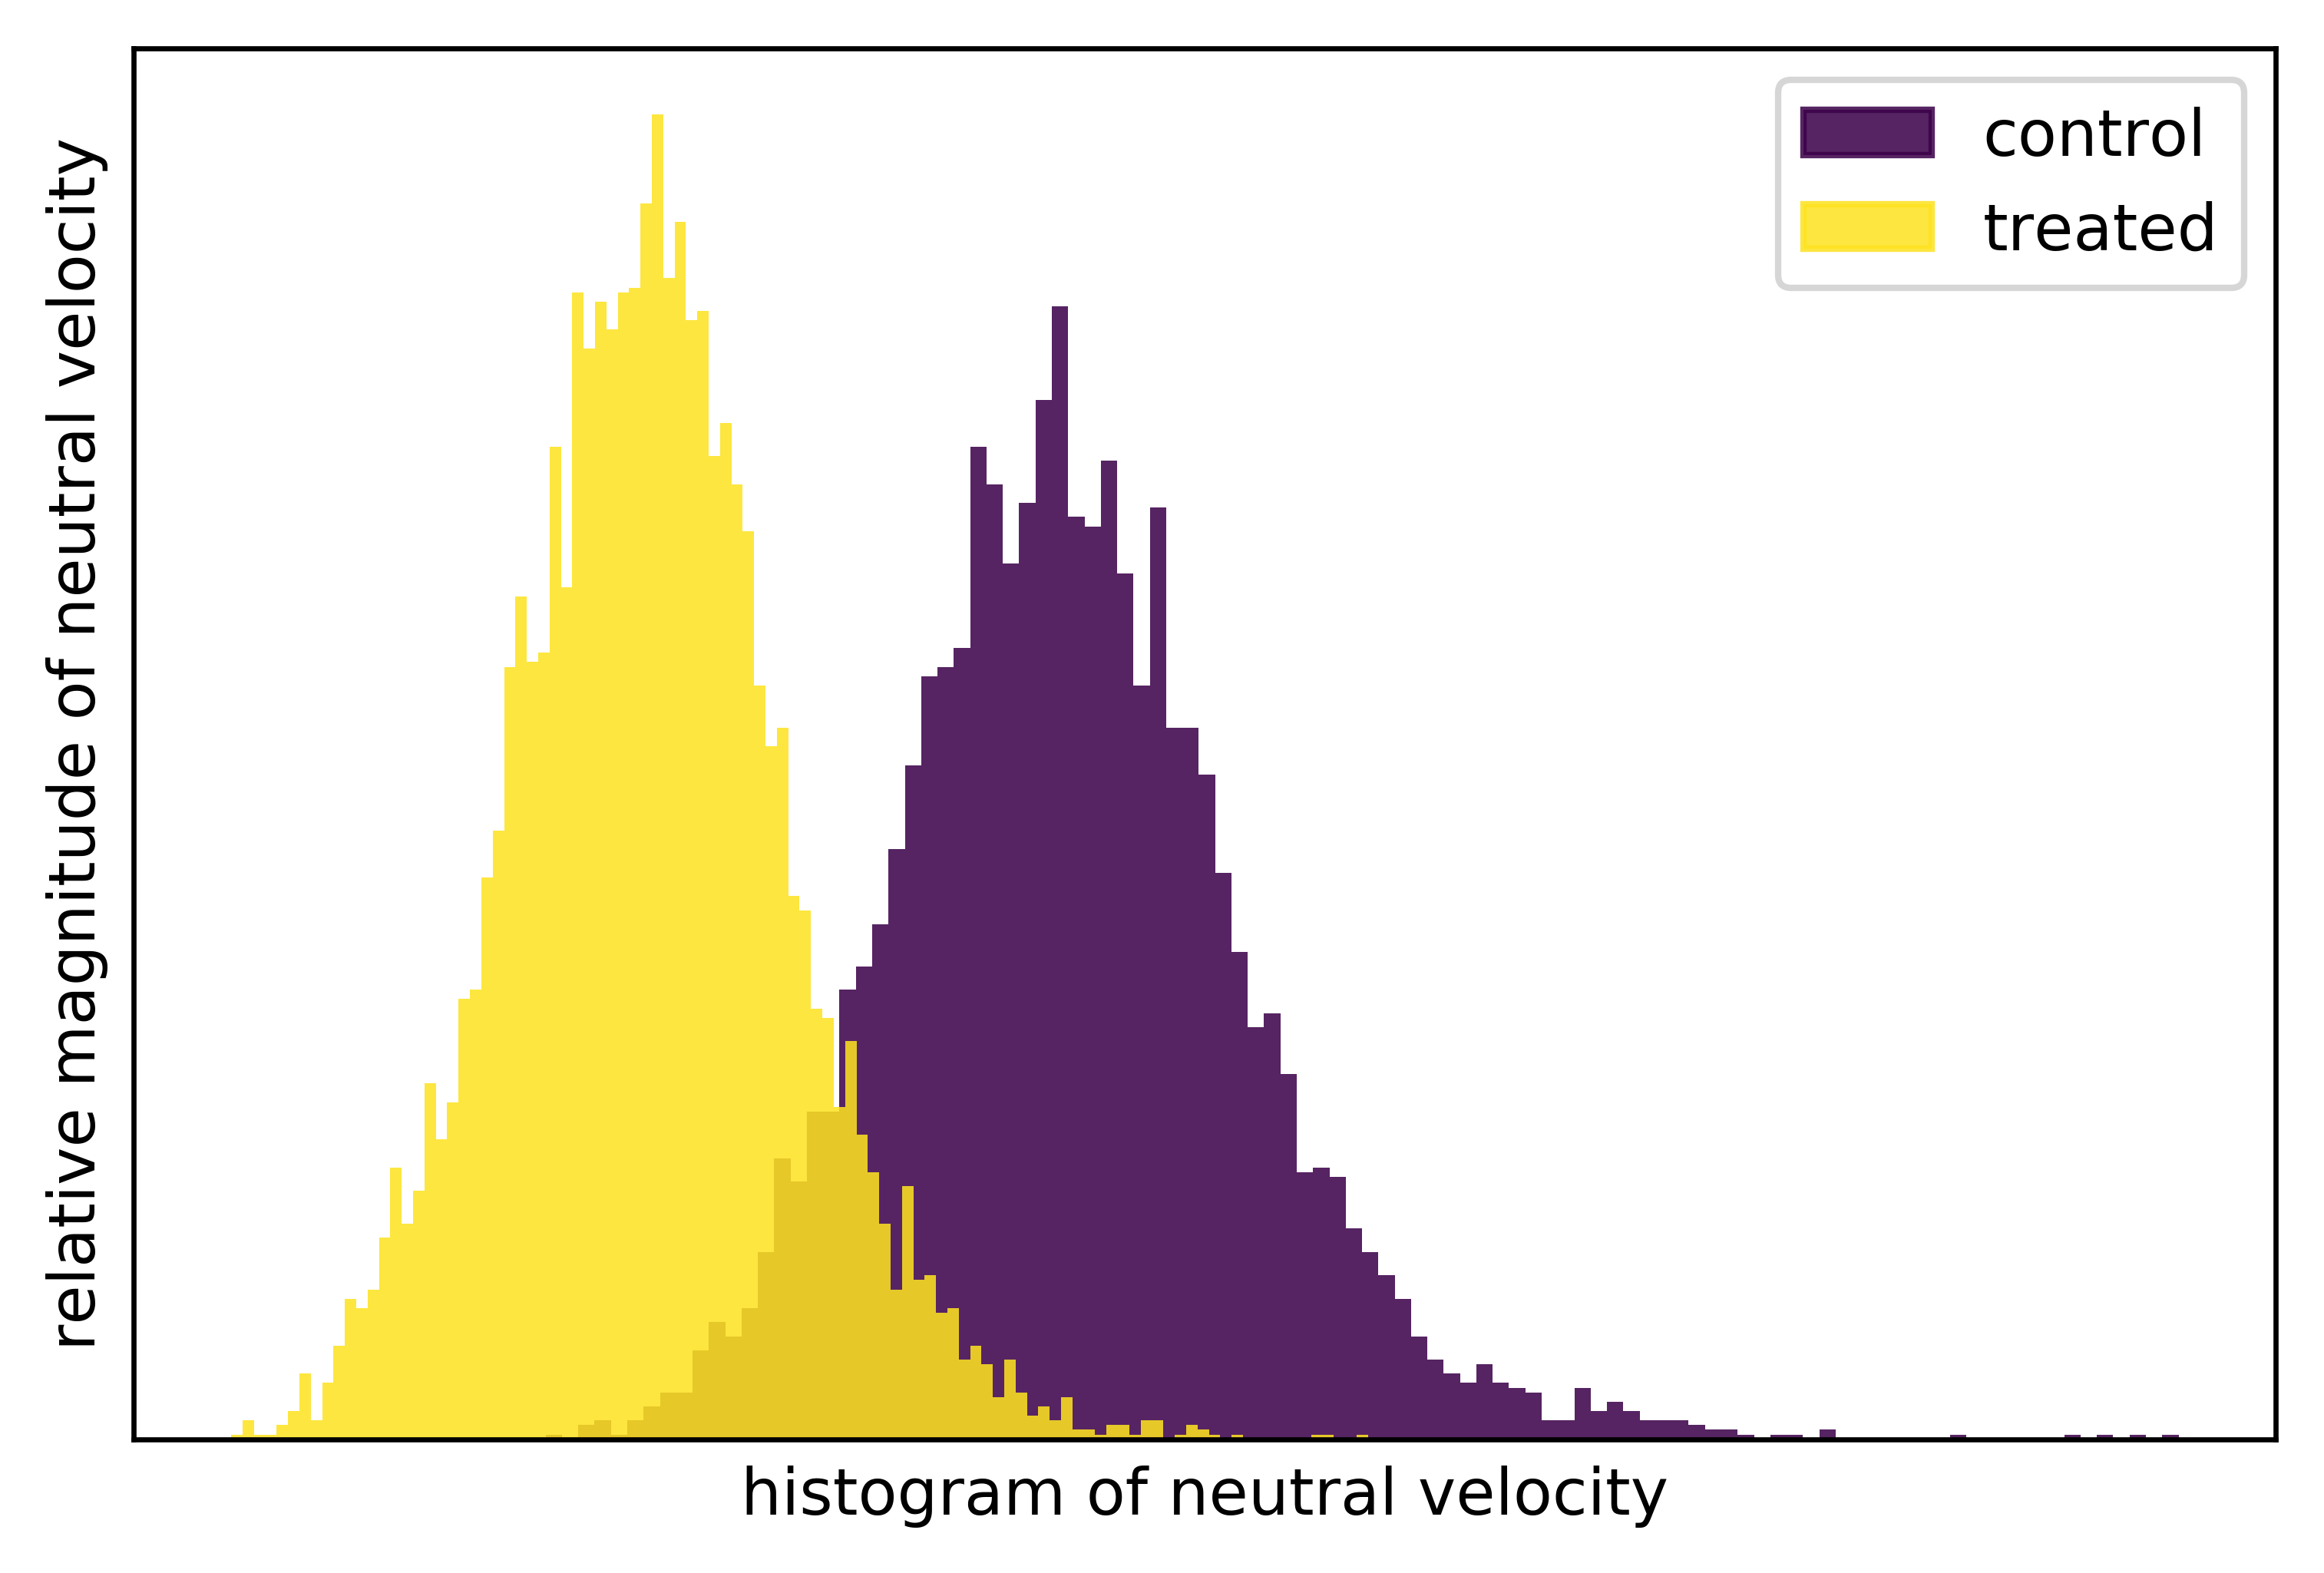

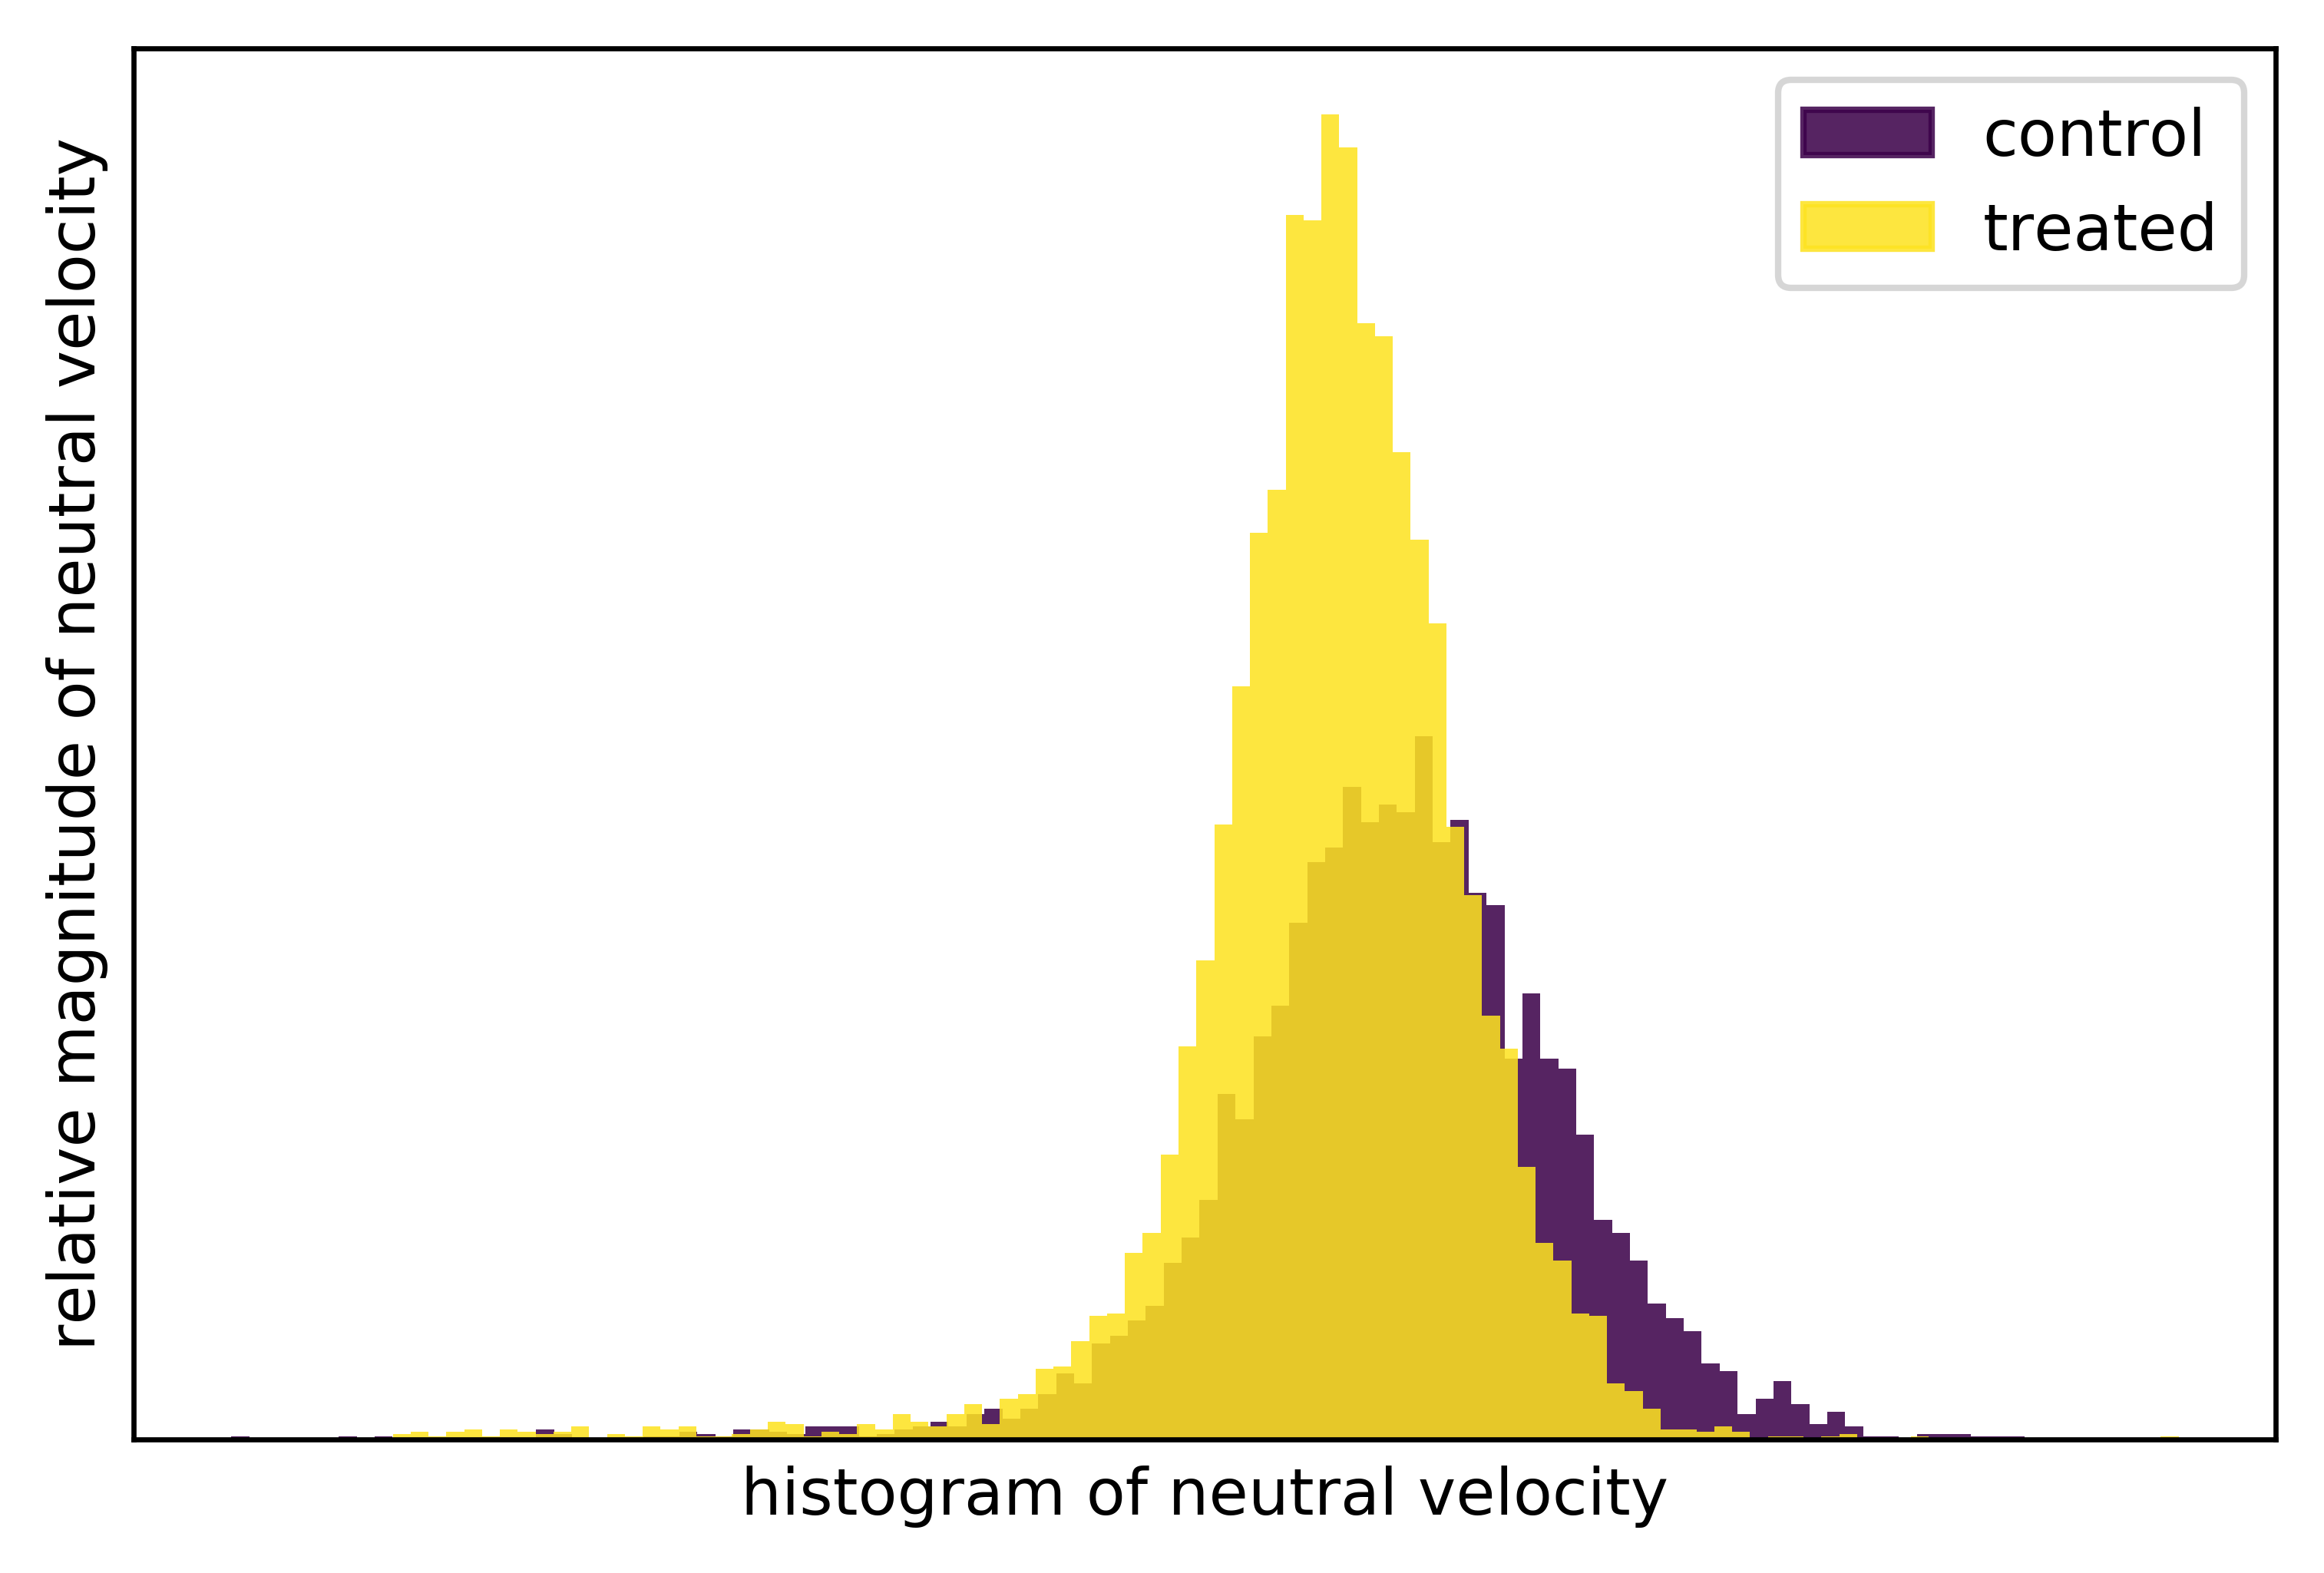

In [33]:
for category, per_batch in gdf.items():    
    print("now printing", category)
    f = plt.figure(dpi=600)
        
    for batch, data in per_batch.items():
        if type(data) != list:
            print(batch, ":", data)
        else:
            plt.xlabel('histogram of neutral velocity')
            plt.ylabel('relative magnitude of neutral velocity')
            plt.xticks([])
            plt.yticks([])
            
            blue_patch = mpatches.Patch(color='#3C024ADD', label='control')
            red_patch = mpatches.Patch(color='#FDE321DD', label='treated')
            plt.legend(handles=[blue_patch, red_patch])

            _ = plt.hist(data, bins=100, color="#3C024ADD" if batch == "control" else "#FDE321DD")
            

# Velocity per louvain cluster

In [34]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [35]:
def get_cell_indices_per_cluster(matrix):
    louvain_indices = {}
    for i, louvain in enumerate(matrix.obs["louvain"]):
        l = louvain_indices.get(louvain, [])
        l.append(i)
        louvain_indices[louvain] = l
    
    return louvain_indices

In [36]:
def lengths_for_cluster(matrix, indices_per_cluster):
    cluster_vel = matrix.layers["velocity"][indices_per_cluster]
    return [numpy.linalg.norm(i) for i in cluster_vel]

In [37]:
def angles_for_cluster(matrix, indices_per_cluster):
    cluster_vel = matrix.layers["velocity"][indices_per_cluster]
    result = []
    for _ in range(1000):
        i = cluster_vel[random.randint(0, len(cluster_vel) - 1)]
        j = cluster_vel[random.randint(0, len(cluster_vel) - 1)]
        result.append(angle_between(i, j) * 180/math.pi)
    return result

shape of velocity layer for batch control : (5347, 4542)
created length and angle distributions for batch control
plotting length distribution for batch control


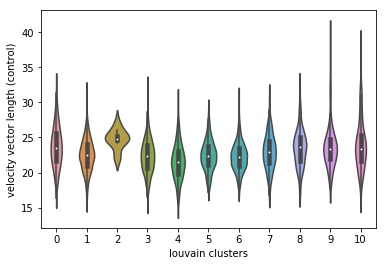

plotting angle distribution for batch control


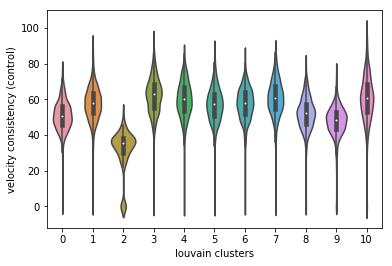

shape of velocity layer for batch treated : (7441, 4542)
created length and angle distributions for batch treated
plotting length distribution for batch treated


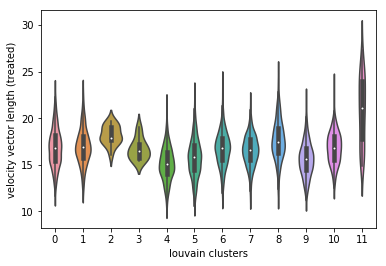

plotting angle distribution for batch treated


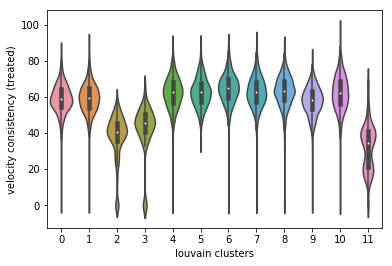

In [38]:
for batch, matrix in batches.items():
    print("shape of velocity layer for batch", batch, ":", matrix.layers["velocity"].shape)
    louvain_indices = get_cell_indices_per_cluster(matrix)
    
    length_distribution = [lengths_for_cluster(matrix, louvain_indices[k]) for k in sorted(louvain_indices.keys())]
    angle_distribution = [angles_for_cluster(matrix, louvain_indices[k]) for k in sorted(louvain_indices.keys())]
    
    print("created length and angle distributions for batch", batch)

    print("plotting length distribution for batch", batch)
    ax = seaborn.violinplot(data=length_distribution)
    ax.set(xlabel='louvain clusters', ylabel='velocity vector length (' + batch + ')')
    plt.show()
    
    print("plotting angle distribution for batch", batch)
    ax = seaborn.violinplot(data=angle_distribution)
    ax.set(xlabel='louvain clusters', ylabel='velocity consistency (' + batch + ')')
    plt.show()